# I'm already getting sidetracked
I started with scraping.ipynb, with the full intention of just scraping and throwing data. However, it occurs to me that there is a simpler, more intuitive question that needs to be answered first before getting too ambitious. That question is: what stocks actually affect each other, if they do at all?

To clarify, I'm asking if some stocks can have their performance predicted by the prior performance of other stocks. For instance, the value of Vangaurd's ETF, VOO, is directly tied to the performance of the companies within its portfolio. Therefore, the expected result is that tracking the performance of the top companies within VOO will tell you something about whether the price of VOO will rise or fall.

In the case of individual stocks, there are similarly direct and intuitive examples of dependency. If the value of a subsidiary company falls, you might expect to see the value of the parent company fall. However, not all inter-market dependencies are so obvious; is my intuition at least. It would be interesting to do a comparative sweep of company stocks to see what stock prices hold predictive power over others.

Note: The existing term for this phenomena is "asset correlation."

## Approach
I'm interested in Echo-State Networks, so I'll use Echo-State Networks to achieve this task. I'll try and see if the methodology is at all sound by using a control case from the past, where we know a direct correlation exists. as well as the causation.

The example I'm using is Bank of America compared to American Express. I am *not* a stock expert, so this is an example pulled from the moist folds of my anus, this website [here](https://einvestingforbeginners.com/stock-correlation-daah/#are). Intuitively(again, to me), the value of a banking company and credit card companies should be correlated because they both rely on the affluence of the general public, not necessarily the succes of a specific product sold. Honestly idk, but I can look at it and say it makes sense.

Going to use a PyTorch-based ESN because PyTorch is pretty based, and I need to learn how to use it. [This is the package I'm using](https://github.com/stefanonardo/pytorch-esn)

In [ ]:
%%capture _
# install PyESN
import  git

!git clone https://github.com/stefanonardo/pytorch-esn.git

%cd pytorch-esn

!python setup.py install

In [1]:
# import required packages
import yfinance as yf # use yfinance to pull the stock information for these two companies
from torchesn.nn import ESN # the esn stuff
from torchesn.utils import prepare_target
import matplotlib.pyplot as plt
import torch
import numpy as np

C:\Users\Timothy\anaconda3\envs\laptop_sketchbook\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Aggregating data
predictor_stock = "BAC" # want to see if Bank of America holds any predictive power over American Express
predicted_stock = "AXP"

start = "2020-01-01"
end = "2022-01-01"

# fetching data with yf.download() because it looks like the yfinance API is down for yf.Ticker()
# stores fetched data in Pandas Dataframes

def fetch_data(predictor, predicted, start, end):
    predictor_history = yf.download(predictor, period = '1mo', start= start, end= end)
    predicted_history = yf.download(predicted, period = '1mo', start= start, end= end)
    return predictor_history, predicted_history

In [4]:
# helper function for plotting fetched data on a plt graph
# args = dataframe{} dfs: dictionary of dataframes stored stock_symbol:dataframe to iterate and plot, string column: name of column you want to plot
def plot(dfs, column):
    for symbol, df in dfs.items():
        plt.plot(df.index, df[column], label= symbol)
    plt.legend()
    plt.show()
    
# helper function for showing results, same format, no column
def outcome_plot(arrays):
    for symbol, array in arrays.items():
        array = array.view(array.size(0),1).detach().numpy()
        plt.plot(array, label= symbol)
    plt.legend()
    plt.show()
    
# NOTE TO SELF: clean up the X-Axis somehow later

# Naive Assumptions and Hypothesis
I'm making the naive assumption that when looking at cases of dependency, the most predictive stock prices will occur in the month (30 days) before the predictor date. I am also making the assumption that the end-of-day Close prices are the most influential prices when considering the perceived stock value.

My hypothesis is that the prior 30 days close values of the predictor stocks will offer no predictive power over the 8th day predicted stock close vlaue.

Edited to add: My prior understanding of the ESN setup was erroneous. In order to get the results that I want, I need to feed in X = predictor data on time scale x, and Y - predicted data on time scale x shifted by n, which is the window size

In [ ]:
# Cuda, if I dare even suggest it
device = torch.device('cuda')
dtype = torch.double
torch.set_default_dtype(dtype)

In [5]:
#setting up esn and clarifying what inputs/outputs are needed/returned

# setting dtype for dependencies
dtype = torch.float64
torch.set_default_dtype(dtype)
print(dtype)

input_size = 1 # just 1 time series
washout = [7] # washout matching hidden_size, I'm a little dumb washout was not what I thought it was
hidden_size = 100 # tweak to my preference
output_size = 1 # only returning a single datapoint

loss_fcn = torch.nn.MSELoss() # loss function, mean-squared error

model = ESN(input_size, hidden_size, output_size)
# model.to(device)

torch.float64


In [6]:
# prepping the data according to the example set by repo

# args = dataframe{} dfs: dictionary of dataframes stored stock_symbol:dataframe, 
# string predictor: predictor symbol, string predicted: prediceted symbol,
# string column: column for values to check against,int n: prior window to examine, [] washout: washout array
def prep_data(dfs, predictor, predicted, column, n, washout):
    if n != 0:
        trX = list(dfs[predictor].reset_index(drop=True)[column][:-n])
        trY = list(dfs[predicted].reset_index(drop=True)[column][n:])
    else:
        trX = list(dfs[predictor].reset_index(drop=True)[column])
        trY = list(dfs[predicted].reset_index(drop=True)[column])
    
    trX = np.expand_dims(trX, axis=1)
    trY = np.expand_dims(trY, axis=1)
    
    trX = torch.from_numpy(trX)
    trY = torch.from_numpy(trY)
    
    trX = trX.view(trX.size(0),1,1)
    trY = trY.view(trY.size(0),1,1)
    
    trY_flat = prepare_target(trY.clone(), [trX.size(0)], washout)
    return trY_flat, trX, trY

In [7]:
# put together

predictor_history, predicted_history = fetch_data(predictor_stock, predicted_stock, start, end)

dfs = {predictor_stock:predictor_history, predicted_stock:predicted_history}

trY_flat, trX, trY = prep_data(dfs, predictor_stock, predicted_stock, "Close", 0, washout)

# recasting for consistency
trY_flat = trY_flat.to(dtype)
trX = trX.to(dtype)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [8]:
# training the model
model(trX, washout, None, trY_flat)
model.fit()

In [9]:
# testing training accuracy
output, hidden = model(trX, washout)
print("Training error:", loss_fcn(output, trY[washout[0]:]).item())

Training error: 36.88798501568516


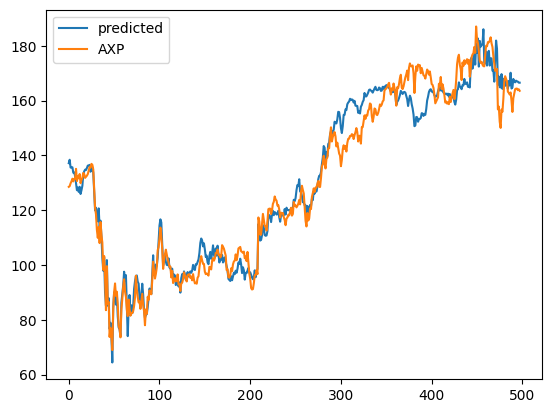

In [10]:
# printing the results for show
display_dict = {"predicted":output, "AXP":trY[washout[0]:]}
outcome_plot(display_dict)

# Things are running
Okay, things are running. This is good, but the current metric that I am using to evaluate the model's performance(Mean Squared Error), doesn't really mean much to me without another model to compare it to. The graph looks great, yes, but I might still be losing a lot of money day-to-day if the MSE is low.

Instead, I'd like to evalute the model more simply: did it predict a rise/fall accurately? We can treat this as a classification task, and compare the performance between pairs of correlated stocks in order to get a more interpretable measure of performance.

In [11]:
# feeding in the straight tensors so we'll compare sizes and convert back to numpys before calculating

def binary_accuracy(predicted_array, real_array):
    predicted_array = predicted_array.view(predicted_array.size(0),1)
    real_array = real_array.view(real_array.size(0),1)
    if (predicted_array.size() != real_array.size()):
        print("Error: Predicted and real arrays are of different sizes. Did you input the right arrays?")
        return None, None, None, None, None, None, None
    else:
        correct = 0
        incorrect = 0
        real_up = 0
        real_down = 0
        predicted_up = 0
        predicted_down = 0
        total = 0
        for i, _ in enumerate(real_array[1:], start = 1):
            total += 1
            if real_array[i] >= real_array[i-1]:
                real_up += 1
            if real_array[i] < real_array[i-1]:
                real_down += 1
            if predicted_array[i] >= predicted_array[i-1]:
                predicted_up += 1
            if predicted_array[i] < predicted_array[i-1]:
                predicted_down += 1
            if (real_array[i] >= real_array[i-1] and predicted_array[i] >= predicted_array[i-1]) or (real_array[i] < real_array[i-1] and predicted_array[i] < predicted_array[i-1]):
                correct += 1
            else:
                incorrect += 1
        return correct, incorrect, total, real_up, real_down, predicted_up, predicted_down

In [12]:
# evaluating the poroportion of correct guesses from the model
correct, incorrect, total, real_up, real_down, predicted_up, predicted_down = binary_accuracy(output, trY[washout[0]:])

if (correct != None):
    print(f"The model correctly predicted stock direction {(correct/total)*100}% of the time")
    print(f"The model incorrectly predicted stock direction {(incorrect/total)*100}% of the time")
    print()
    print(f"The percentage of predictable ups/stables was {(real_up/total)*100}%")
    print(f"The percentage of predictable downs was {(real_down/total)*100}%")
    print()
    print(f"The model predicted a favorable price change {(predicted_up/total)*100}% of the time")
    print(f"The model predicted an unfavorable price change {(predicted_down/total)*100}% of the time")

The model correctly predicted stock direction 75.85513078470825% of the time
The model incorrectly predicted stock direction 24.14486921529175% of the time

The percentage of predictable ups/stables was 51.91146881287726%
The percentage of predictable downs was 48.08853118712273%

The model predicted a favorable price change 53.52112676056338% of the time
The model predicted an unfavorable price change 46.478873239436616% of the time


In [13]:
# turning the summary into a function because why not

def summarize(predicted, real):
    correct, incorrect, total, real_up, real_down, predicted_up, predicted_down = binary_accuracy(predicted, real)

    if (correct != None):
        print(f"The model correctly predicted stock direction {(correct/total)*100}% of the time")
        print(f"The model incorrectly predicted stock direction {(incorrect/total)*100}% of the time")
        print()
        print(f"The percentage of predictable ups/stables was {(real_up/total)*100}%")
        print(f"The percentage of predictable downs was {(real_down/total)*100}%")
        print()
        print(f"The model predicted a favorable price change {(predicted_up/total)*100}% of the time")
        print(f"The model predicted an unfavorable price change {(predicted_down/total)*100}% of the time")
    else:
        print("Something went wrong, figure it out")

In [14]:
# fetching newer data, and testing the performance
predictor_stock = "BAC"
predicted_stock = "AXP"

start = "2022-01-01"
end = "2024-01-01"

washout = [7]

predictor_history, predicted_history = fetch_data(predictor_stock, predicted_stock, start, end)

dfs = {predictor_stock:predictor_history, predicted_stock:predicted_history}

teY_flat, teX, teY = prep_data(dfs, predictor_stock, predicted_stock, "Close", 0, washout)

# recasting for consistency
teY_flat = teY_flat.to(dtype)
teX = teX.to(dtype)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [15]:
test_output, test_hidden = model(teX, [0], hidden)

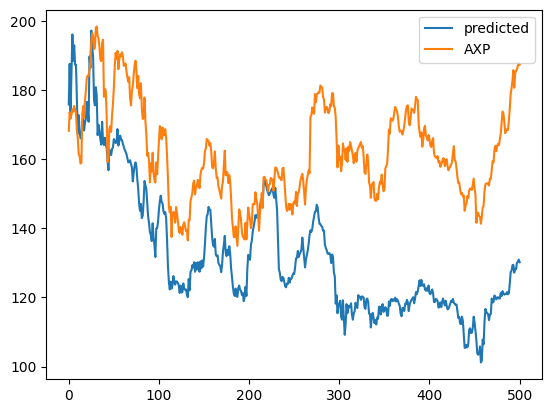

In [16]:
# plot the test results
display_dict = {"predicted":test_output, "AXP":teY}
outcome_plot(display_dict)

In [17]:
# summarize
summarize(test_output, teY)

The model correctly predicted stock direction 72.6% of the time
The model incorrectly predicted stock direction 27.400000000000002% of the time

The percentage of predictable ups/stables was 50.0%
The percentage of predictable downs was 50.0%

The model predicted a favorable price change 47.0% of the time
The model predicted an unfavorable price change 53.0% of the time


# Discussion
It looks like things are working as expected. Believe it or not, stock prices look random! Wow! Let's try it out with some intuitively uncorrelated stocks, and see how it performs

In [18]:
# Lets compare the stock prices of Nvidia and uhhh, GWRS

predictor_stock = "NVDA"
predicted_stock = "GWRS"

start = "2020-01-01"
end = "2022-01-01"

washout = [7]

predictor_history, predicted_history = fetch_data(predictor_stock, predicted_stock, start, end)

dfs = {predictor_stock:predictor_history, predicted_stock:predicted_history}

teY_flat, teX, teY = prep_data(dfs, predictor_stock, predicted_stock, "Close", 0, washout)

# recasting for consistency
teY_flat = teY_flat.to(dtype)
trX = trX.to(dtype)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


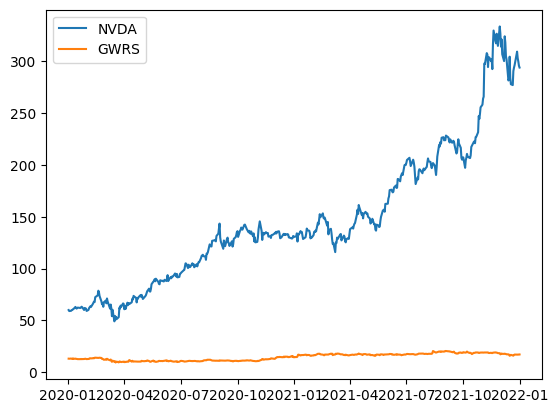

In [19]:
# What do the stocks look like
plot(dfs, "Close")

In [20]:
random_model = ESN(input_size, hidden_size, output_size)

In [21]:
random_model(trX, washout, None, trY_flat)
random_model.fit()

In [22]:
# testing training accuracy
output, hidden = random_model(trX, washout)
print("Training error:", loss_fcn(output, trY[washout[0]:]).item())

Training error: 36.487829300968386


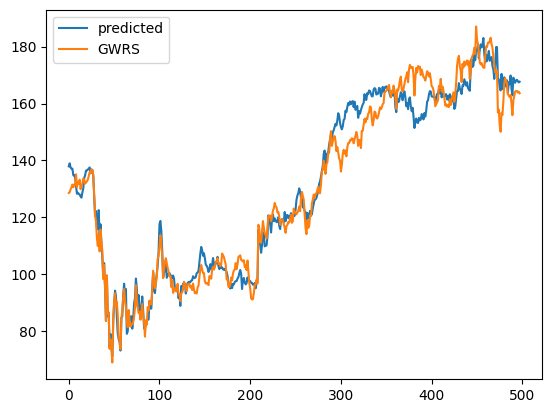

In [23]:
display_dict = {"predicted":output, "GWRS":trY[washout[0]:]}
outcome_plot(display_dict)

In [25]:
# testing on test data
predictor_stock = "NVDA"
predicted_stock = "GWRS"

start = "2022-01-01"
end = "2024-01-01"

washout = [7]

predictor_history, predicted_history = fetch_data(predictor_stock, predicted_stock, start, end)

dfs = {predictor_stock:predictor_history, predicted_stock:predicted_history}

teY_flat, teX, teY = prep_data(dfs, predictor_stock, predicted_stock, "Close", 0, washout)

# recasting for consistency
teY_flat = teY_flat.to(dtype)
trX = trX.to(dtype)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


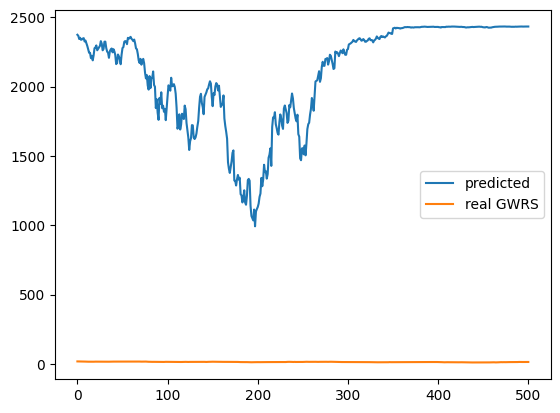

Test error: 4486864.18319026
The model correctly predicted stock direction 59.199999999999996% of the time
The model incorrectly predicted stock direction 40.8% of the time

The percentage of predictable ups/stables was 48.6%
The percentage of predictable downs was 51.4%

The model predicted a favorable price change 53.400000000000006% of the time
The model predicted an unfavorable price change 46.6% of the time


C:\Users\Timothy\anaconda3\envs\laptop_sketchbook\lib\site-packages\torch-1.13.1-py3.7-win-amd64.egg\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([501, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [26]:
test_output, test_hidden = random_model(teX, [0], hidden)

# plot
outcome_dict = {"predicted":test_output, "real GWRS":teY}
outcome_plot(outcome_dict)

# summarize
print("Test error:", loss_fcn(test_output, teY[washout[0]]).item())
summarize(test_output, teY)

# WOW!
Lookie, NVDA holds very little predictive power over GWRS. The accuracy of our model reflects this fact. Yippee.